In [69]:
import pandas as pd
import geopandas
import unicodedata

import matplotlib.pyplot as plt


In [70]:
# pegando o mapão (substituir por pegar do banco)

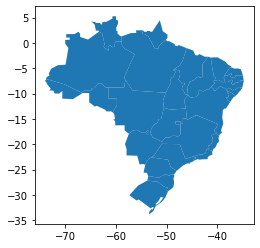

In [74]:
df = pd.read_csv("cursos-prouni.csv")
file = open("br-states.json")
geodata = geopandas.read_file(file)
df.rename(columns={'uf_busca':'id'}, inplace=True)
df1=df.groupby("id").mean()

df3=pd.merge(df1,geodata,on="id")
gdf3 = geopandas.GeoDataFrame(
    df3, geometry=df3["geometry"])
gdf3.plot()

 - Relação entre bolsas e notas
 - Relação entre mensalidade e notas

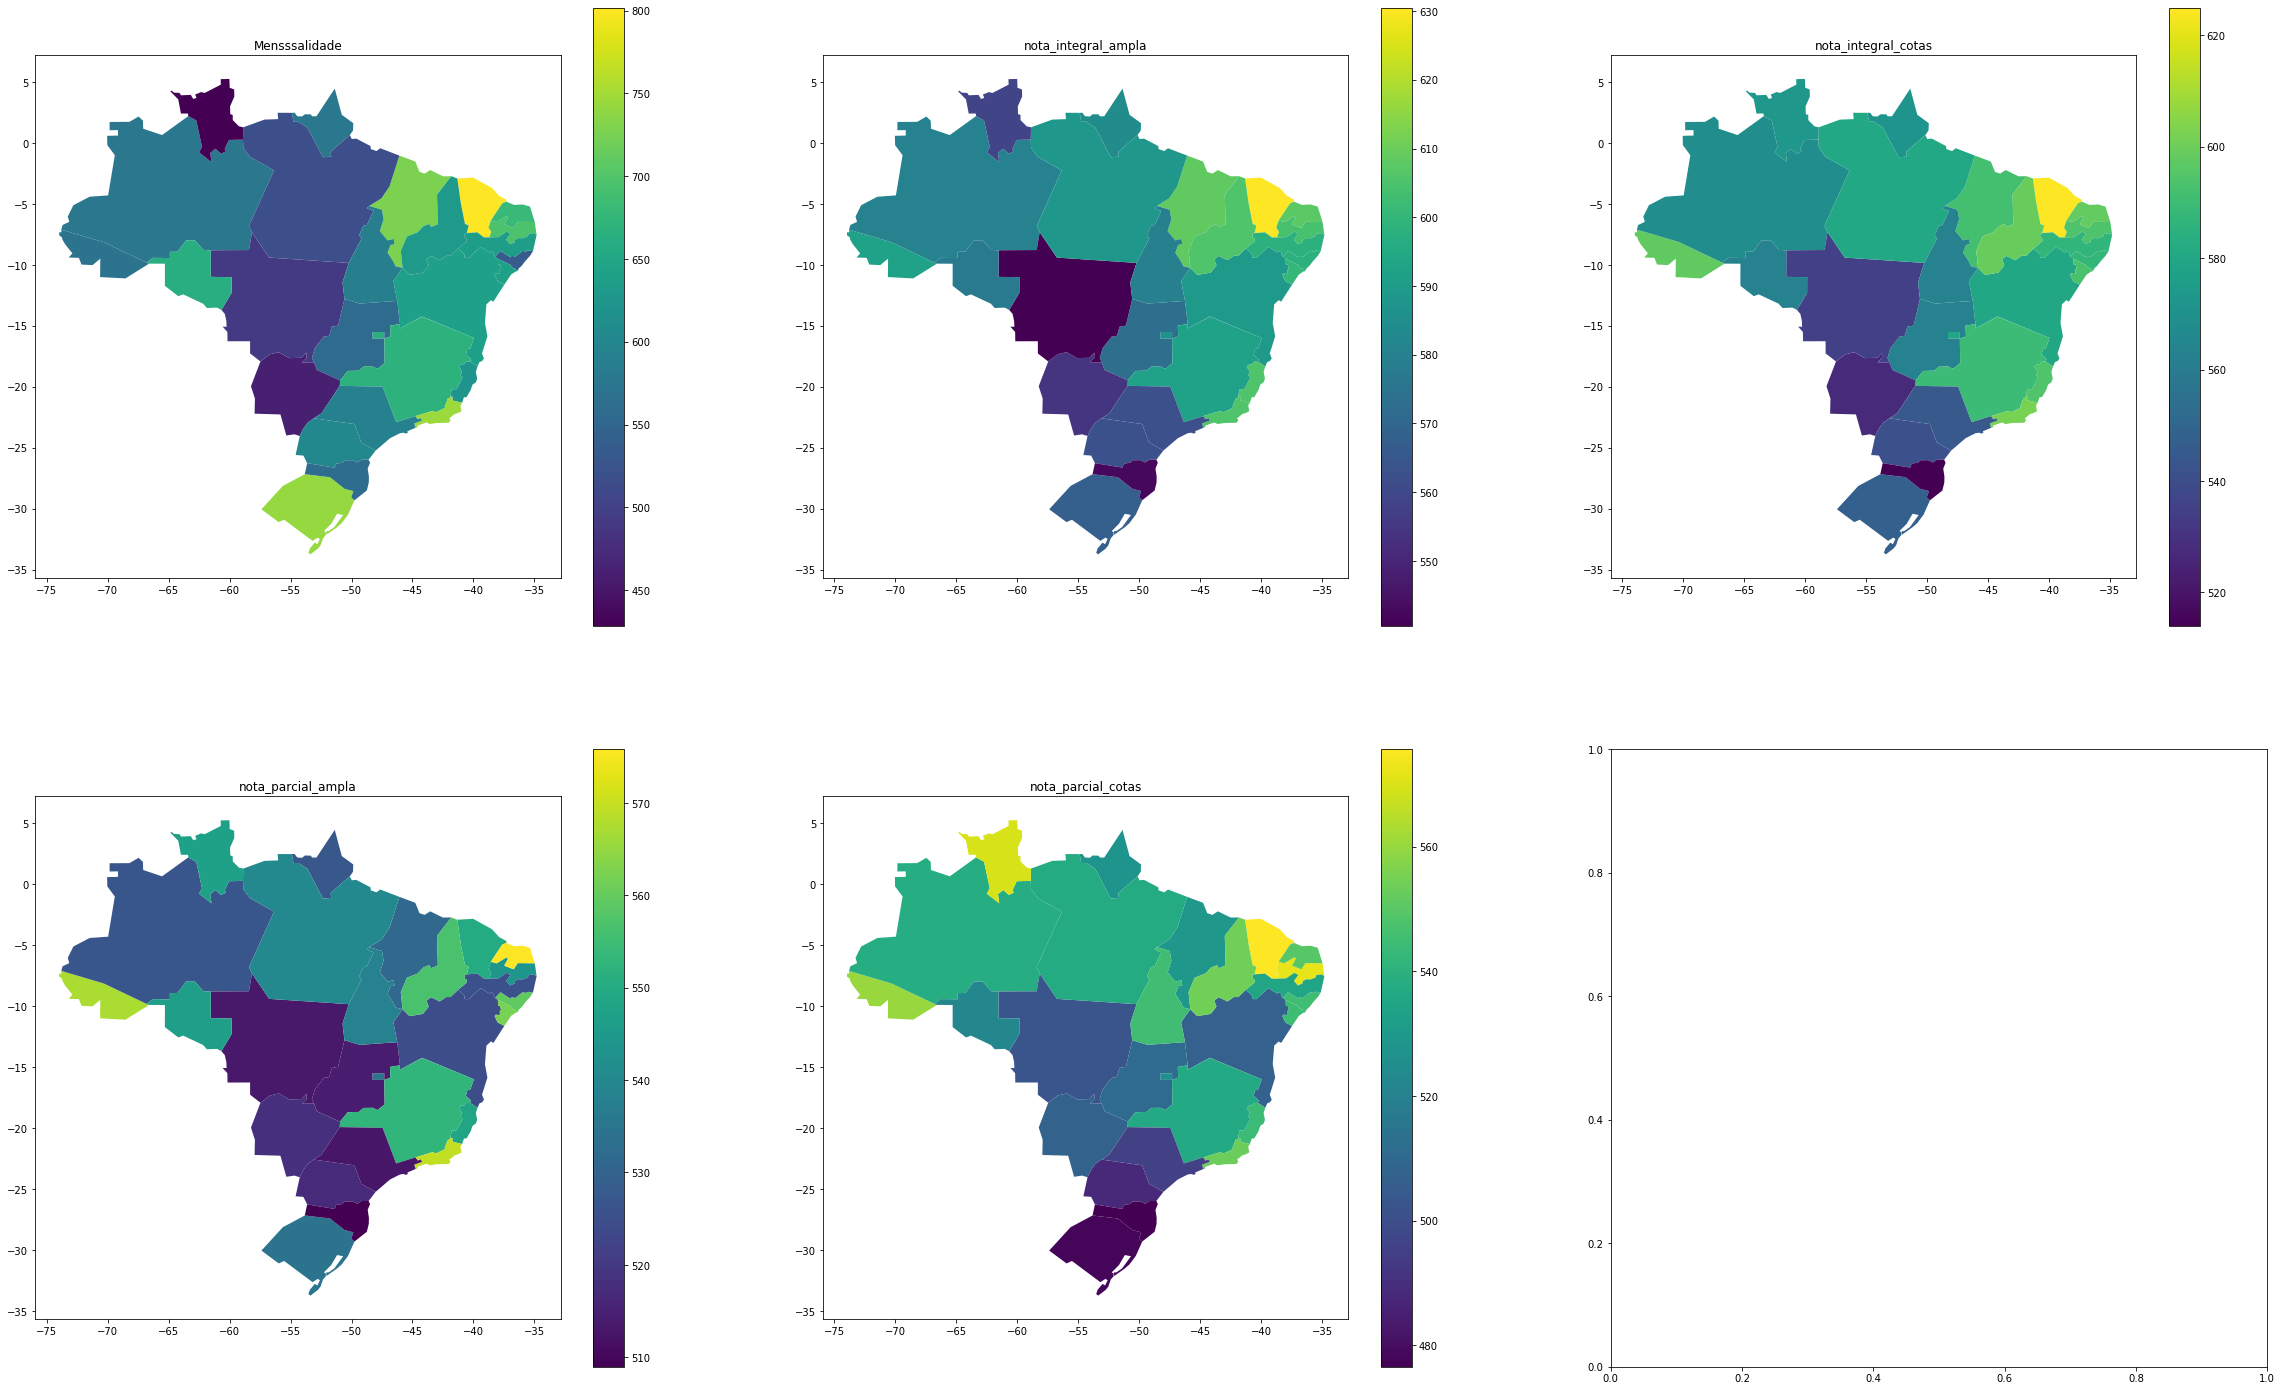

In [72]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=[40,25])

axes[0][0].set_title("Mensssalidade")
axes[0][1].set_title("nota_integral_ampla")
axes[0][2].set_title("nota_integral_cotas")
axes[1][0].set_title("nota_parcial_ampla")
axes[1][1].set_title("nota_parcial_cotas")

gdf3.plot(column="mensalidade", ax=axes[0][0], legend=True)
gdf3.plot(column="nota_integral_ampla", ax=axes[0][1], legend=True)
gdf3.plot(column="nota_integral_cotas", ax=axes[0][2], legend=True)
gdf3.plot(column="nota_parcial_ampla", ax=axes[1][0], legend=True)
gdf3.plot(column="nota_parcial_cotas", ax=axes[1][1], legend=True)


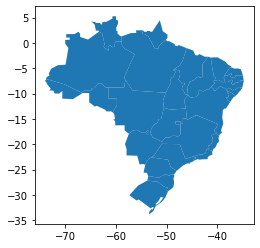

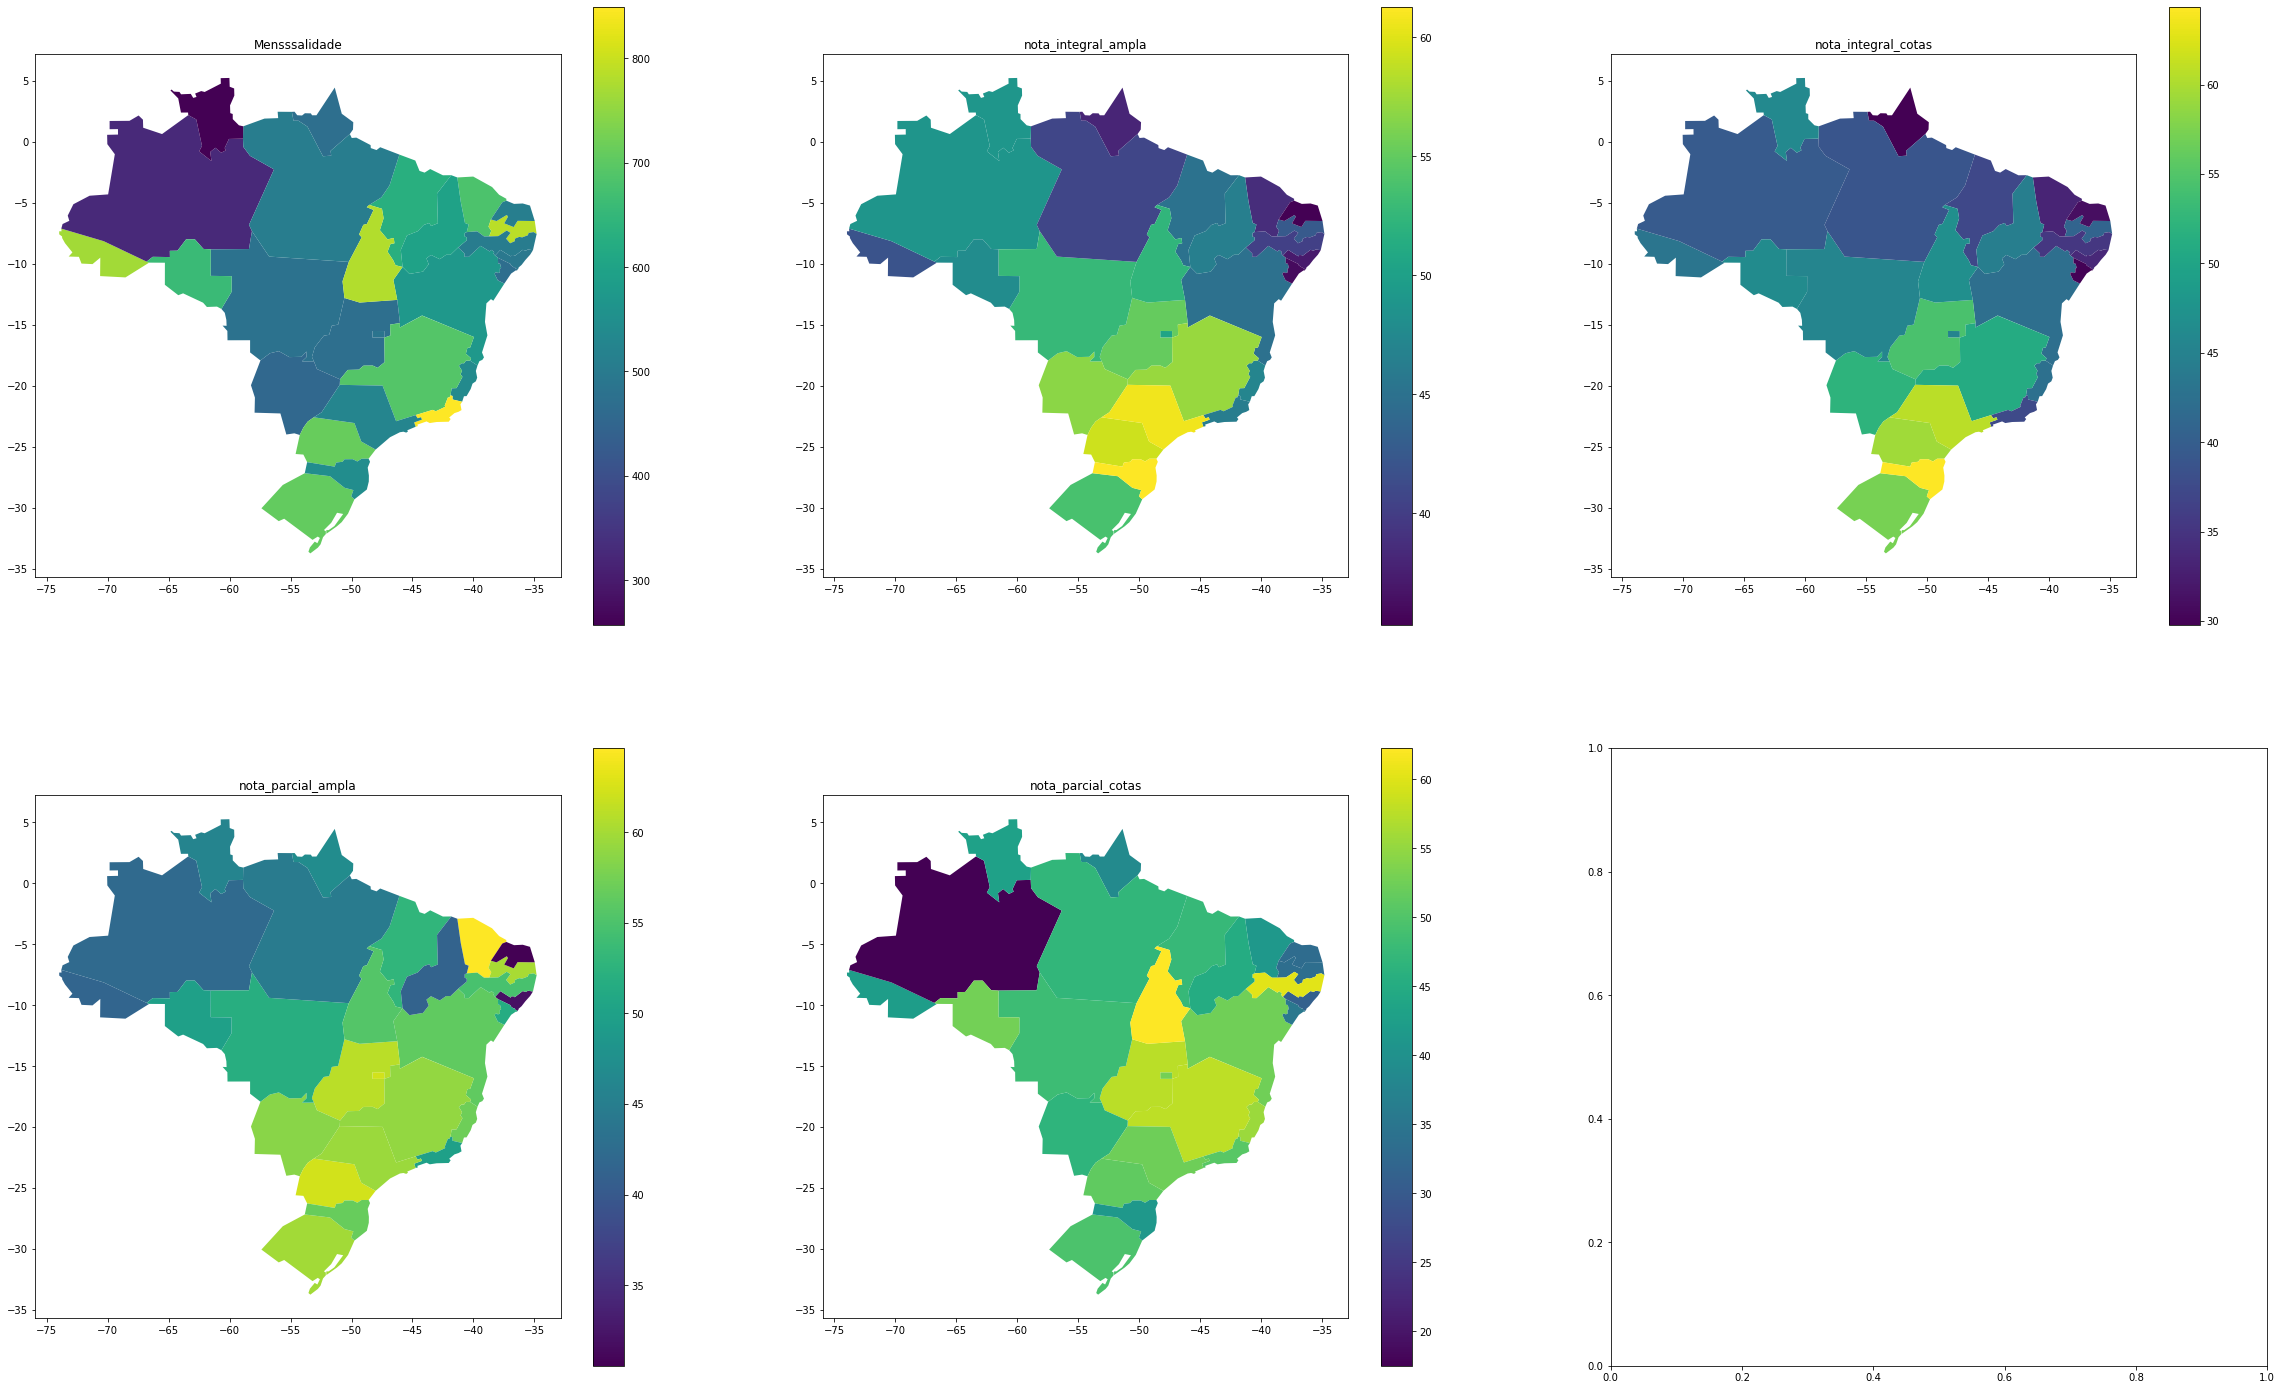

In [76]:
df1=df.groupby("id").std()

df3=pd.merge(df1,geodata,on="id")
gdf3 = geopandas.GeoDataFrame(
    df3, geometry=df3["geometry"])
gdf3.plot()

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=[40,25])

axes[0][0].set_title("Mensssalidade")
axes[0][1].set_title("nota_integral_ampla")
axes[0][2].set_title("nota_integral_cotas")
axes[1][0].set_title("nota_parcial_ampla")
axes[1][1].set_title("nota_parcial_cotas")

gdf3.plot(column="mensalidade", ax=axes[0][0], legend=True)
gdf3.plot(column="nota_integral_ampla", ax=axes[0][1], legend=True)
gdf3.plot(column="nota_integral_cotas", ax=axes[0][2], legend=True)
gdf3.plot(column="nota_parcial_ampla", ax=axes[1][0], legend=True)
gdf3.plot(column="nota_parcial_cotas", ax=axes[1][1], legend=True)

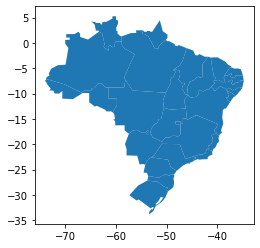

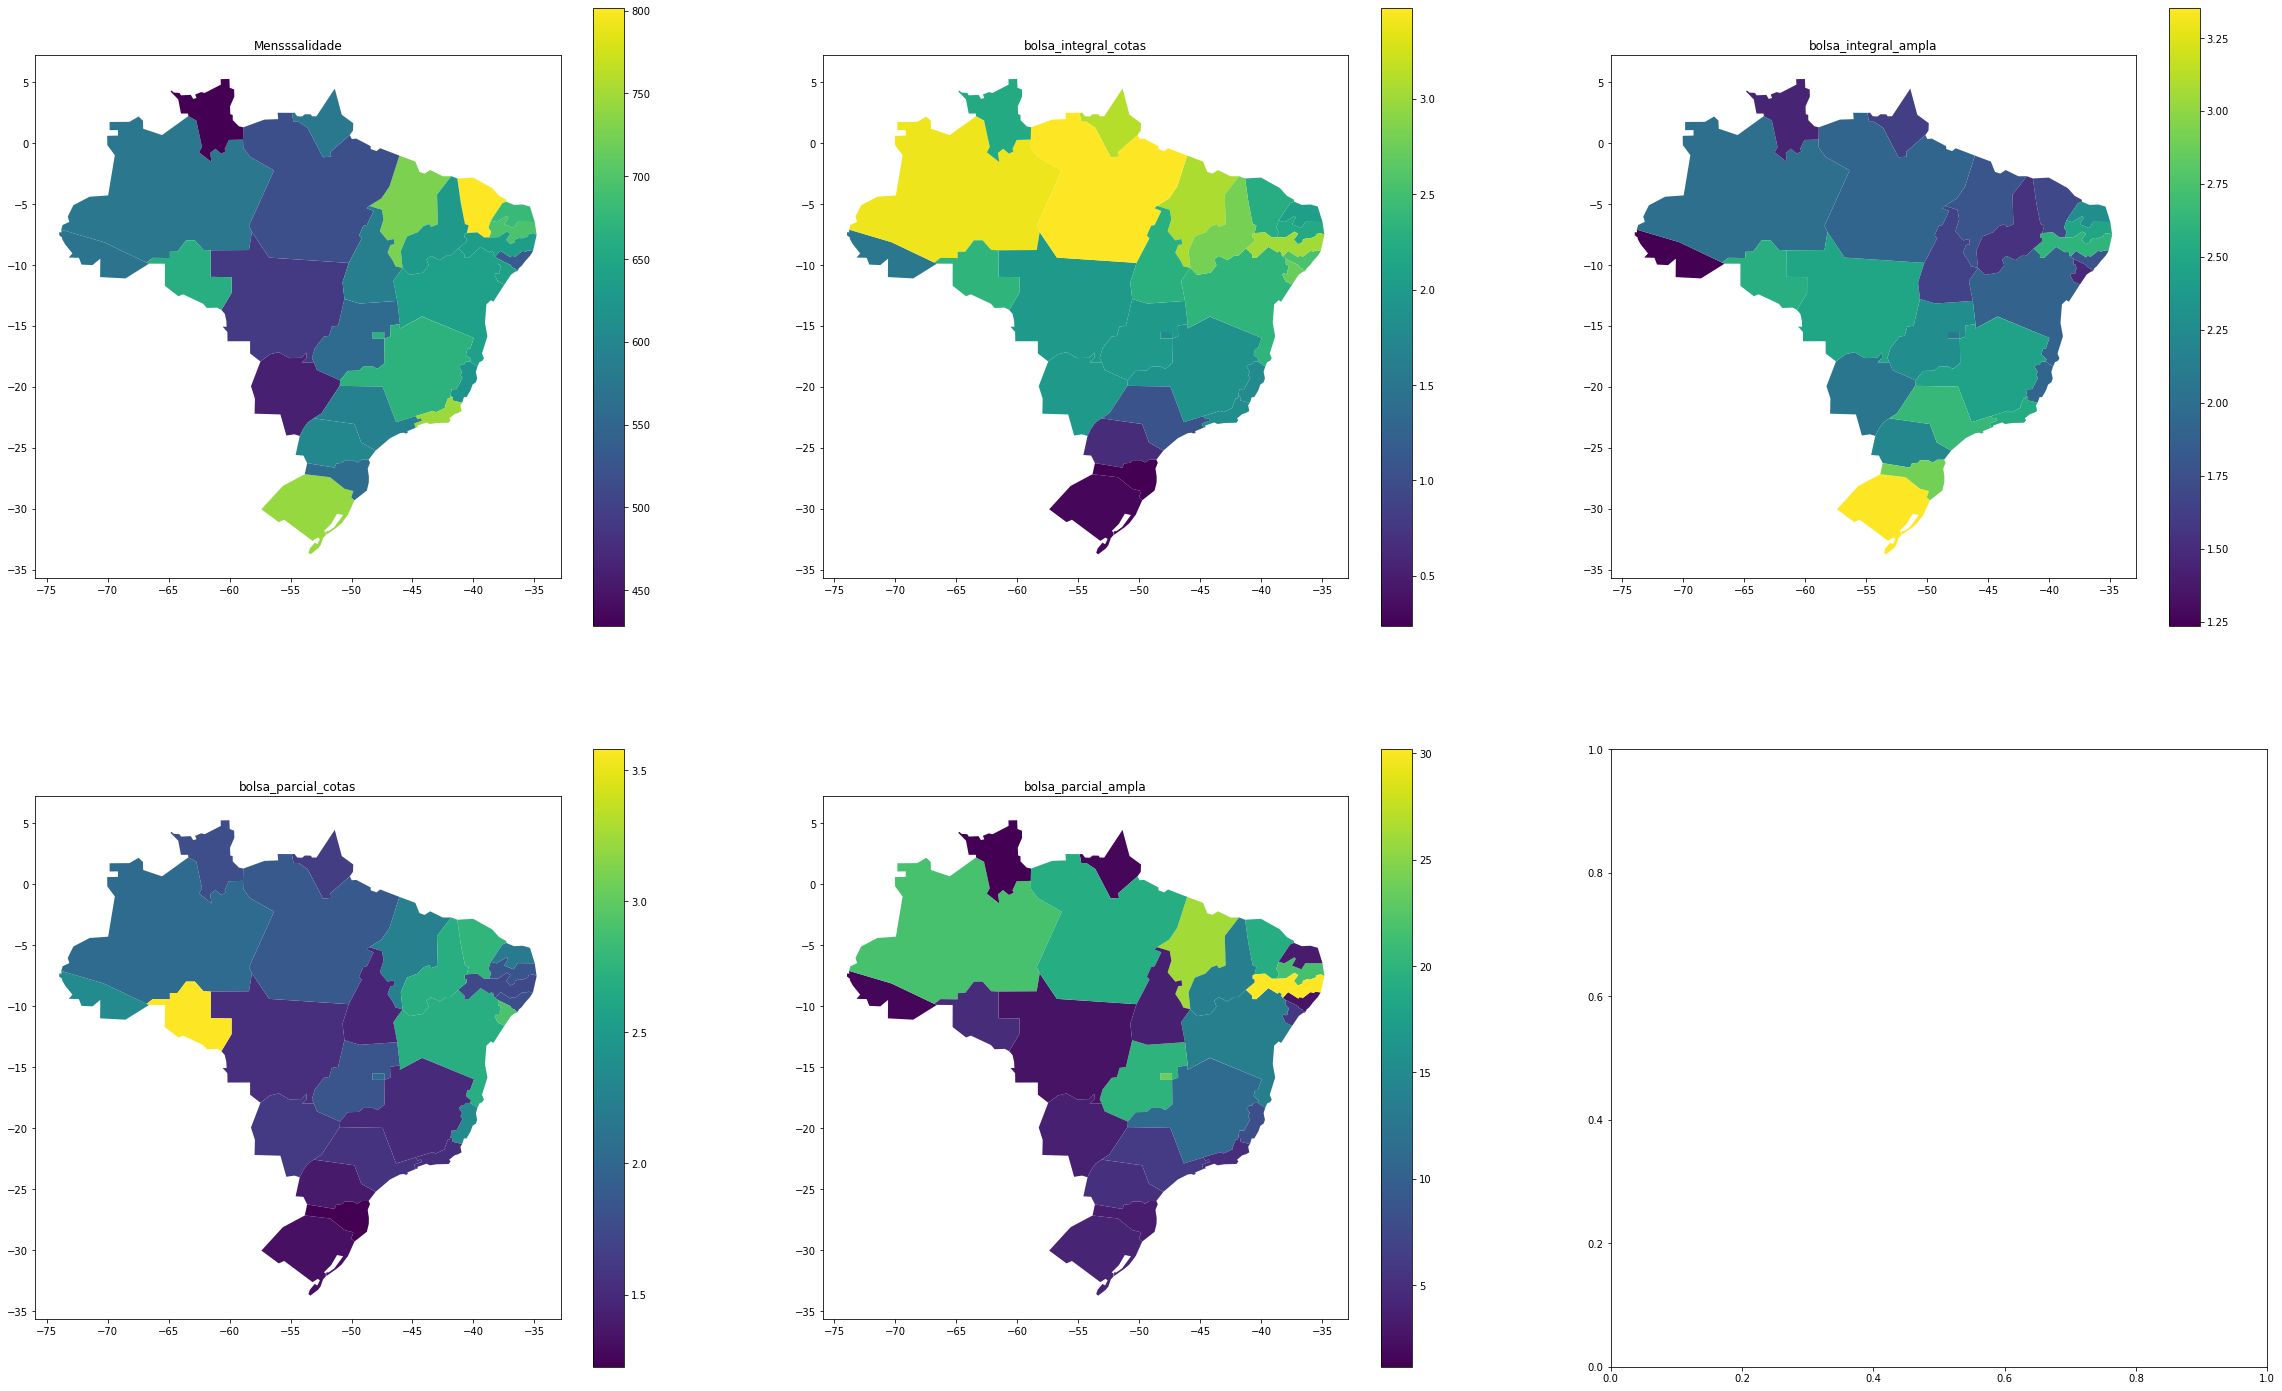

In [77]:
df1=df.groupby("id").mean()

df3=pd.merge(df1,geodata,on="id")
gdf3 = geopandas.GeoDataFrame(
    df3, geometry=df3["geometry"])
gdf3.plot()

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=[40,25])

axes[0][0].set_title("Mensssalidade")
axes[0][1].set_title("bolsa_integral_cotas")
axes[0][2].set_title("bolsa_integral_ampla")
axes[1][0].set_title("bolsa_parcial_cotas")
axes[1][1].set_title("bolsa_parcial_ampla")

gdf3.plot(column="mensalidade", ax=axes[0][0], legend=True)
gdf3.plot(column="bolsa_integral_cotas", ax=axes[0][1], legend=True)
gdf3.plot(column="bolsa_integral_ampla", ax=axes[0][2], legend=True)
gdf3.plot(column="bolsa_parcial_cotas", ax=axes[1][0], legend=True)
gdf3.plot(column="bolsa_parcial_ampla", ax=axes[1][1], legend=True)

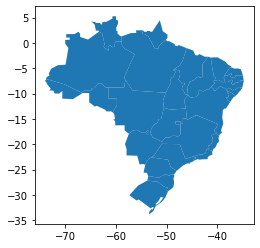

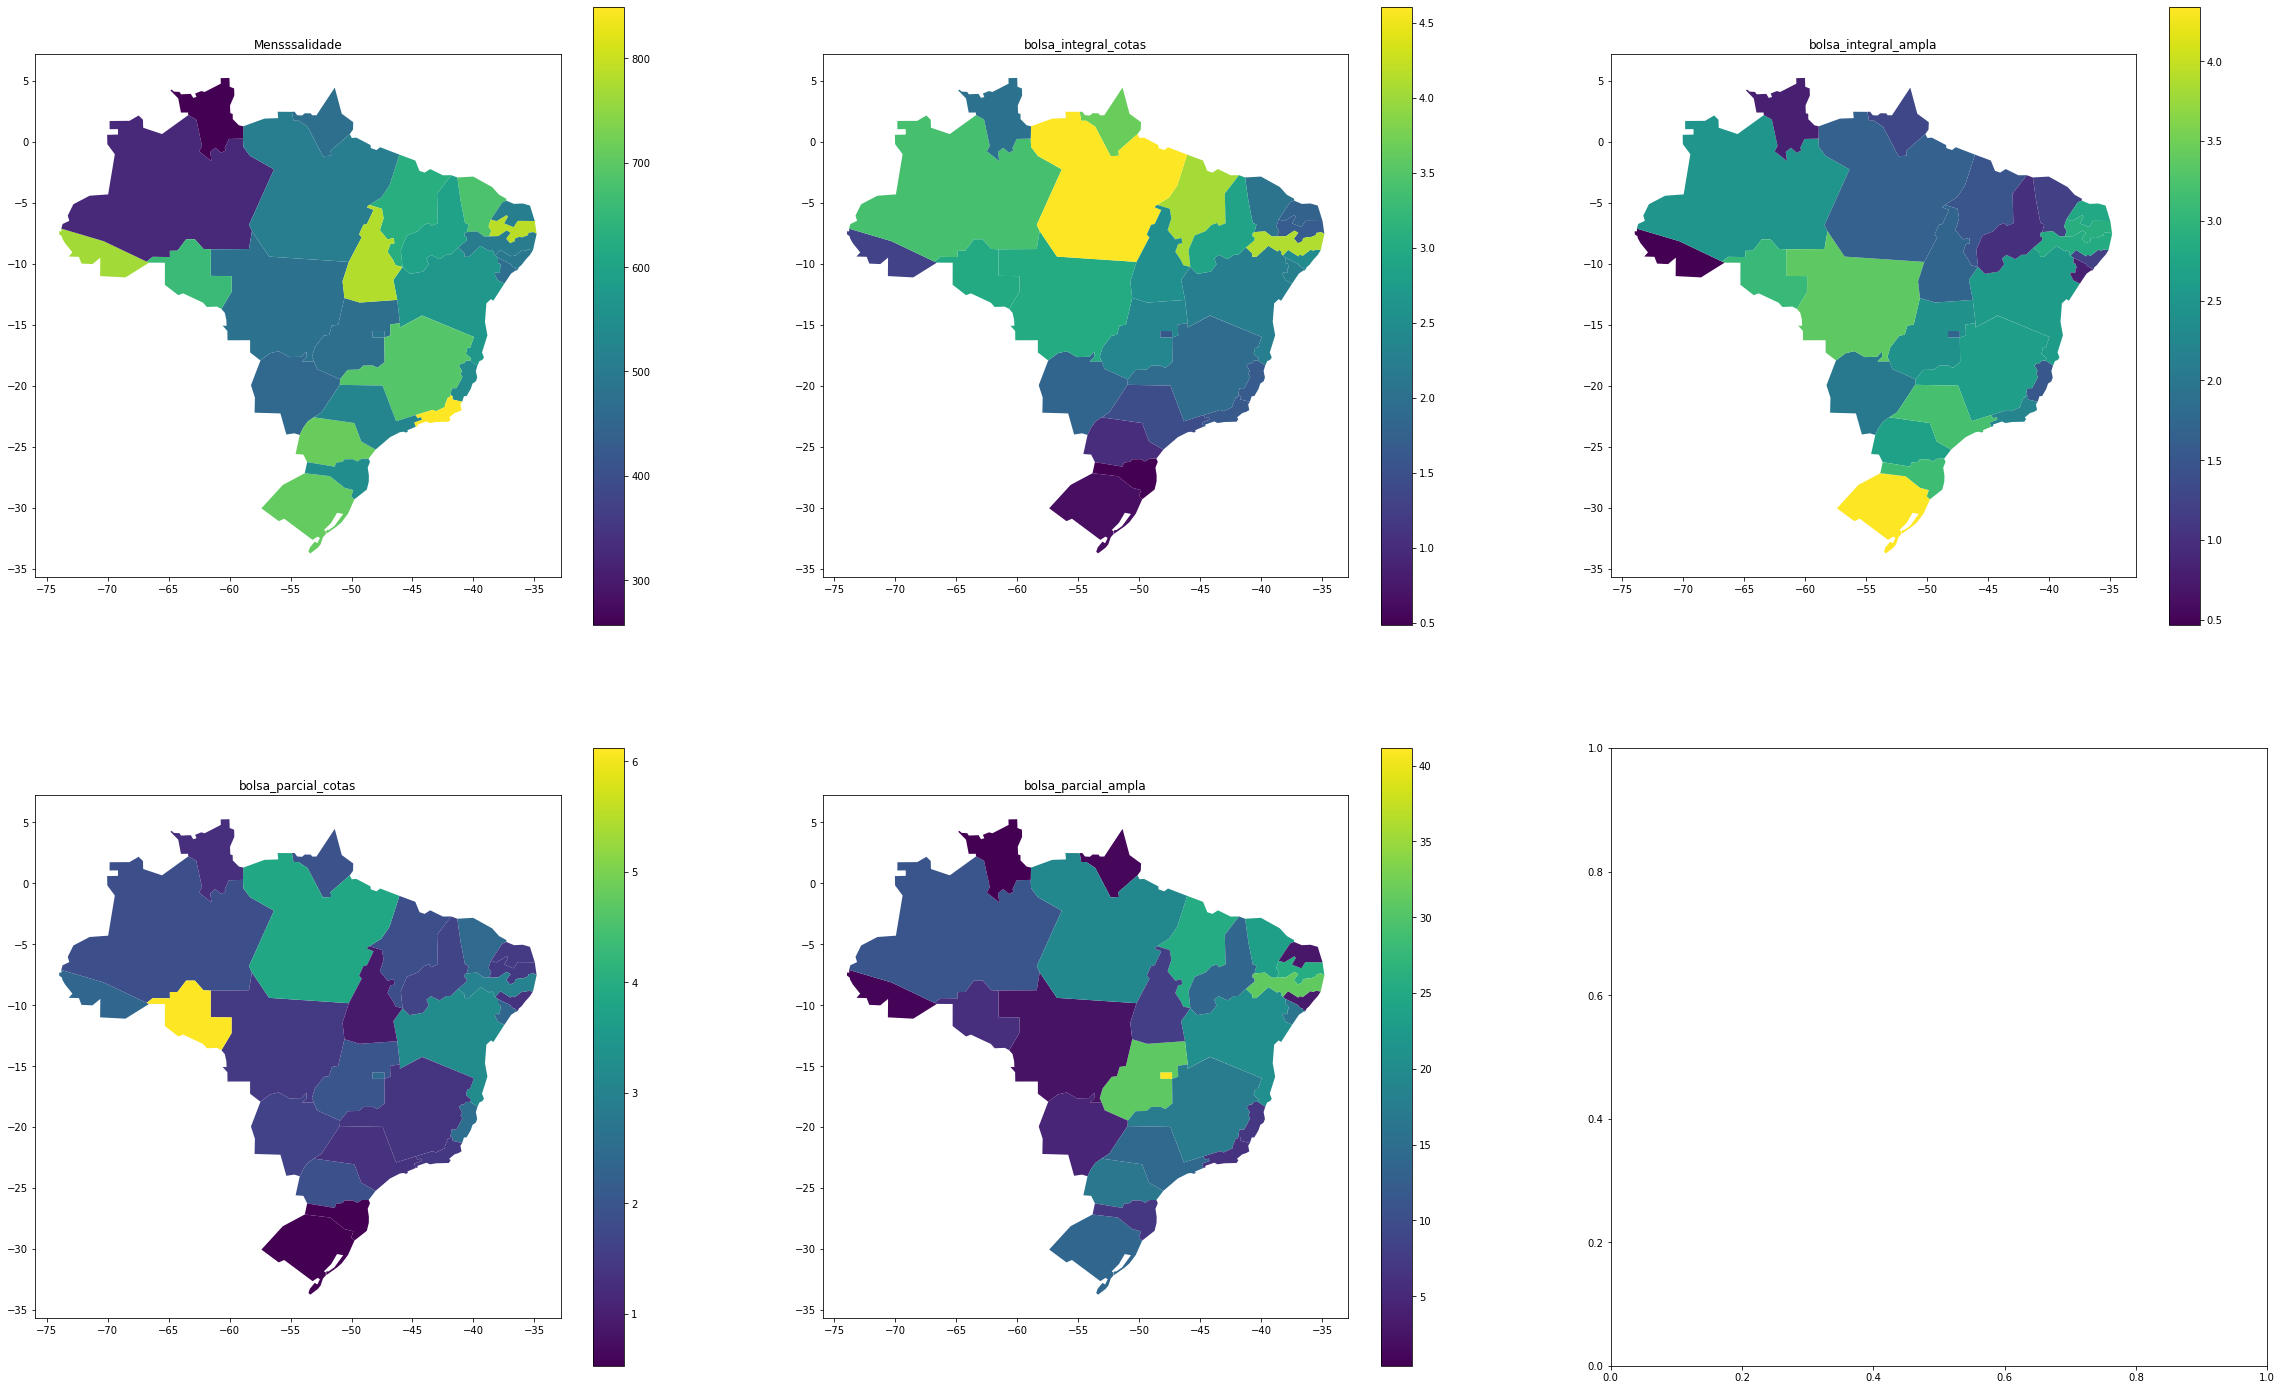

In [78]:
df1=df.groupby("id").std()

df3=pd.merge(df1,geodata,on="id")
gdf3 = geopandas.GeoDataFrame(
    df3, geometry=df3["geometry"])
gdf3.plot()

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=[40,25])

axes[0][0].set_title("Mensssalidade")
axes[0][1].set_title("bolsa_integral_cotas")
axes[0][2].set_title("bolsa_integral_ampla")
axes[1][0].set_title("bolsa_parcial_cotas")
axes[1][1].set_title("bolsa_parcial_ampla")

gdf3.plot(column="mensalidade", ax=axes[0][0], legend=True)
gdf3.plot(column="bolsa_integral_cotas", ax=axes[0][1], legend=True)
gdf3.plot(column="bolsa_integral_ampla", ax=axes[0][2], legend=True)
gdf3.plot(column="bolsa_parcial_cotas", ax=axes[1][0], legend=True)
gdf3.plot(column="bolsa_parcial_ampla", ax=axes[1][1], legend=True)